In [ ]:
!pip install prophet
!pip install statsmodels tensorflow xgboost scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from datetime import timedelta

In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv('cleaned_drsi.csv')

# Preview the data
print(df.head())


         Date  \
0  1988-02-01   
1  1988-03-01   
2  1988-04-01   
3  1988-05-01   
4  1988-06-01   

   RSI:Retail of computer and telecomms equipment (val sa):All Business Index  \
0                                               84.2                            
1                                               81.8                            
2                                               86.0                            
3                                               88.1                            
4                                               89.0                            

   RSI:Predominantly food stores (val sa):All Business Index  \
0                                               25.2           
1                                               25.3           
2                                               25.5           
3                                               25.4           
4                                               25.6           

   RSI:Retail cosmetic & 

In [ ]:
# Rename columns for simplicity
df.columns = ['Date', 'Computer_Telecom', 'Food_Stores', 'Cosmetics', 'Clothing']

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

def generate_future_dates(start_date, periods, freq='M'):
    return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)

print(df.head())


            Computer_Telecom  Food_Stores  Cosmetics  Clothing
Date                                                          
1988-02-01              84.2         25.2       13.4      30.6
1988-03-01              81.8         25.3       13.8      30.5
1988-04-01              86.0         25.5       14.1      30.8
1988-05-01              88.1         25.4       14.4      31.1
1988-06-01              89.0         25.6       14.3      32.1


In [ ]:
# --- Outlier Removal using Z-Score ---
from scipy.stats import zscore

# Apply z-score and mask values above threshold (e.g. z > 3)
z_scores = df.apply(zscore)
df_clean = df.mask((z_scores > 3) | (z_scores < -3))

# Optionally fill removed outliers via interpolation
df_clean = df_clean.interpolate(method='linear')

# --- Noise Reduction using Moving Average (Rolling Mean) ---
df_smooth = df_clean.rolling(window=3, center=True).mean()

<Figure size 1200x600 with 0 Axes>

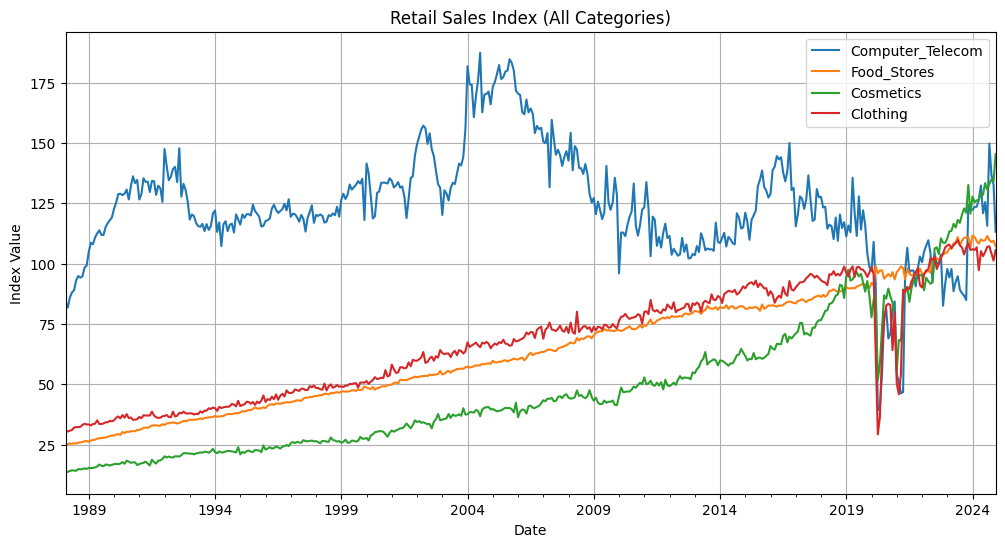

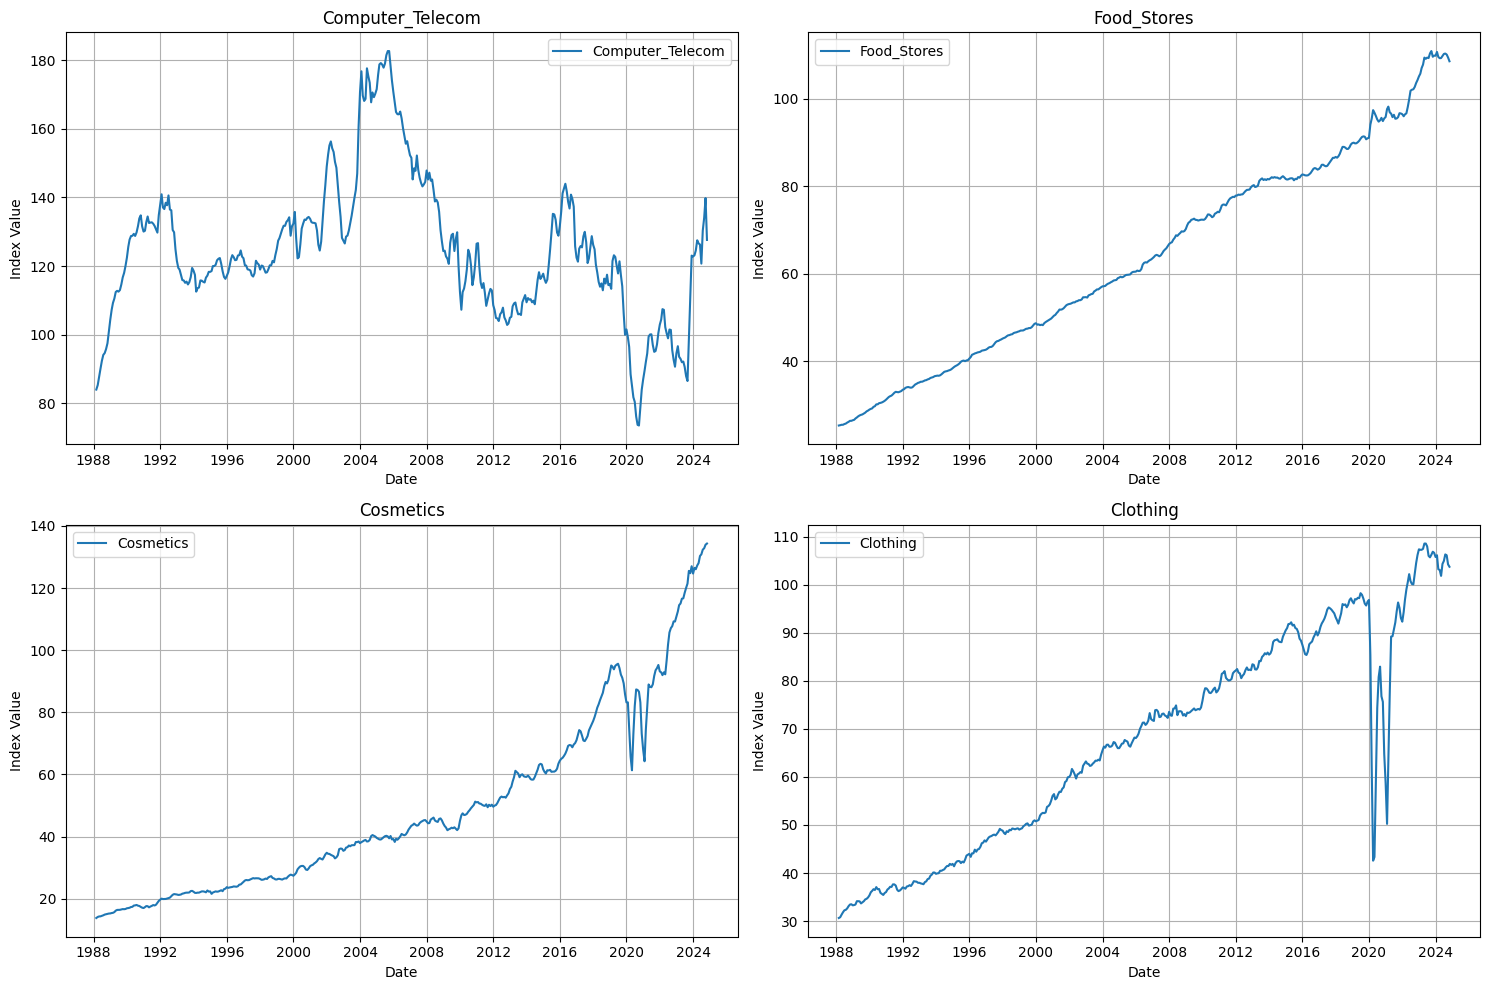

In [ ]:
import matplotlib.pyplot as plt

# --- PLOT 1: All time series together ---
plt.figure(figsize=(12, 6))
df.plot(title='Retail Sales Index (All Categories)', figsize=(12, 6))
plt.ylabel('Index Value')
plt.grid(True)
plt.show()

# --- PLOT 2: Individual plots for each category ---
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    plt.subplot(2, 2, i+1)
    plt.plot(df_smooth.index, df_smooth[column], label=column)
    plt.title(column)
    plt.xlabel("Date")
    plt.ylabel("Index Value")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

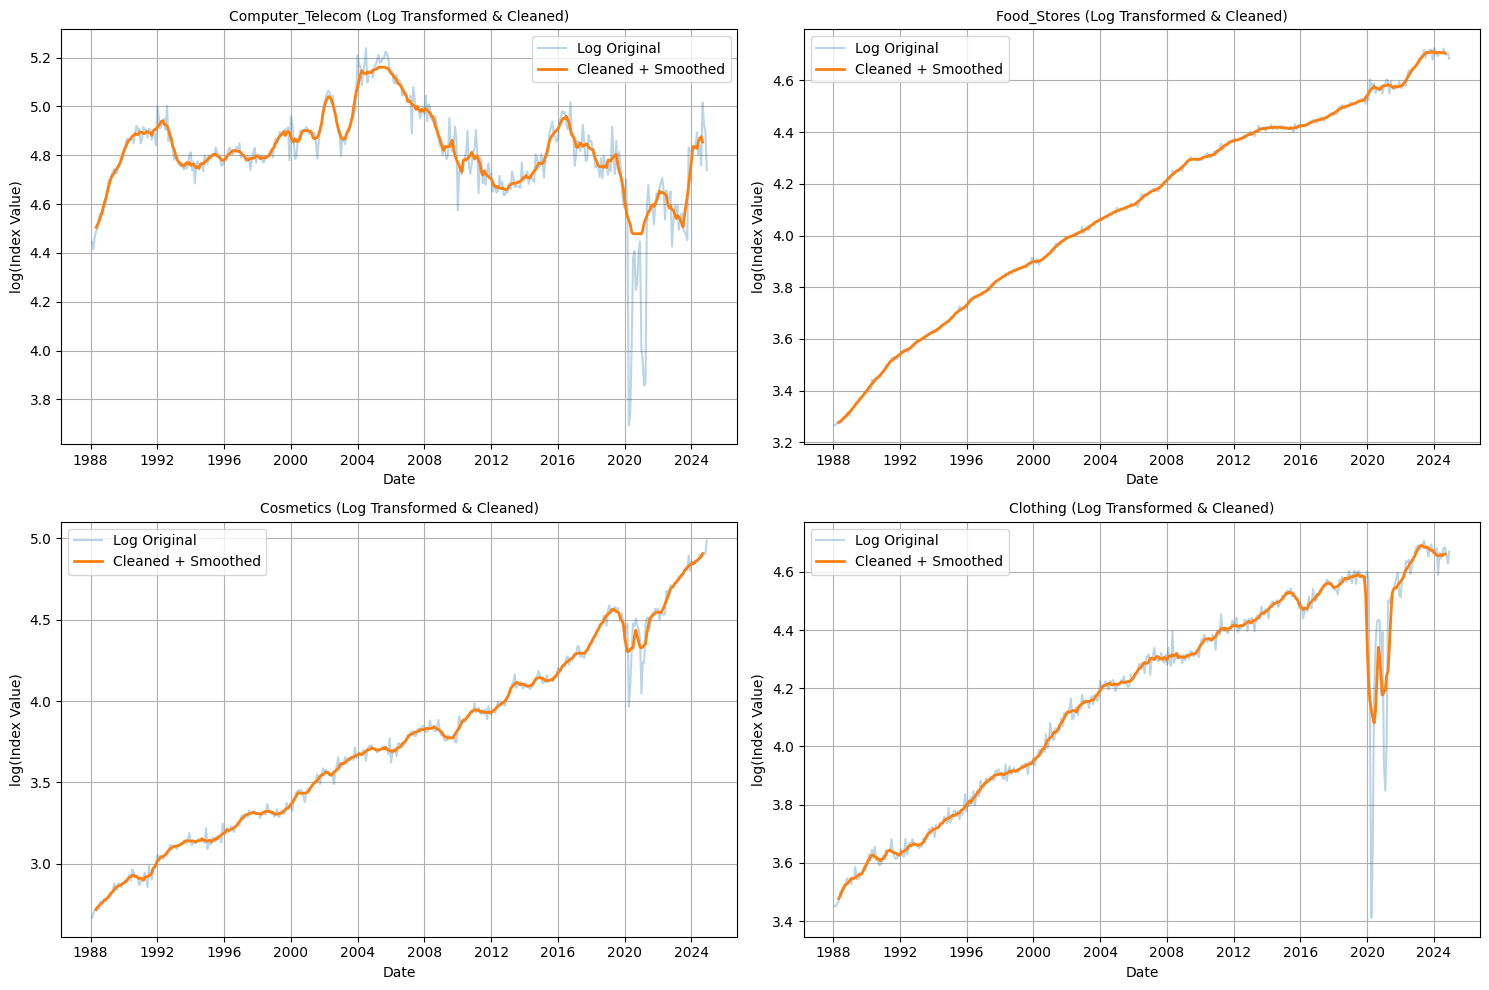

In [ ]:
import numpy as np

# --- STEP 2: Log Transform (stabilize growth patterns) ---
df_log = np.log1p(df)  # log(1 + x) to handle zeros

# --- STEP 3: IQR-based Outlier Removal ---
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

df_clean = df_log.apply(remove_outliers_iqr)

# --- STEP 4: Smoothing (7-month rolling mean) ---
df_smooth = df_clean.rolling(window=7, center=True).mean()

# --- STEP 5: Visualization ---
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    plt.subplot(2, 2, i + 1)
    plt.plot(df_log.index, df_log[column], label='Log Original', alpha=0.3)
    plt.plot(df_smooth.index, df_smooth[column], label='Cleaned + Smoothed', linewidth=2)
    plt.title(f"{column} (Log Transformed & Cleaned)", fontsize=10)
    plt.xlabel("Date")
    plt.ylabel("log(Index Value)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


# Prophet Model

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4268erw6/wotmsyvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4268erw6/g1m8d9u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46564', 'data', 'file=/tmp/tmp4268erw6/wotmsyvi.json', 'init=/tmp/tmp4268erw6/g1m8d9u5.json', 'output', 'file=/tmp/tmp4268erw6/prophet_modelsjv9ldqn/prophet_model-20250427200450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4268erw6/w

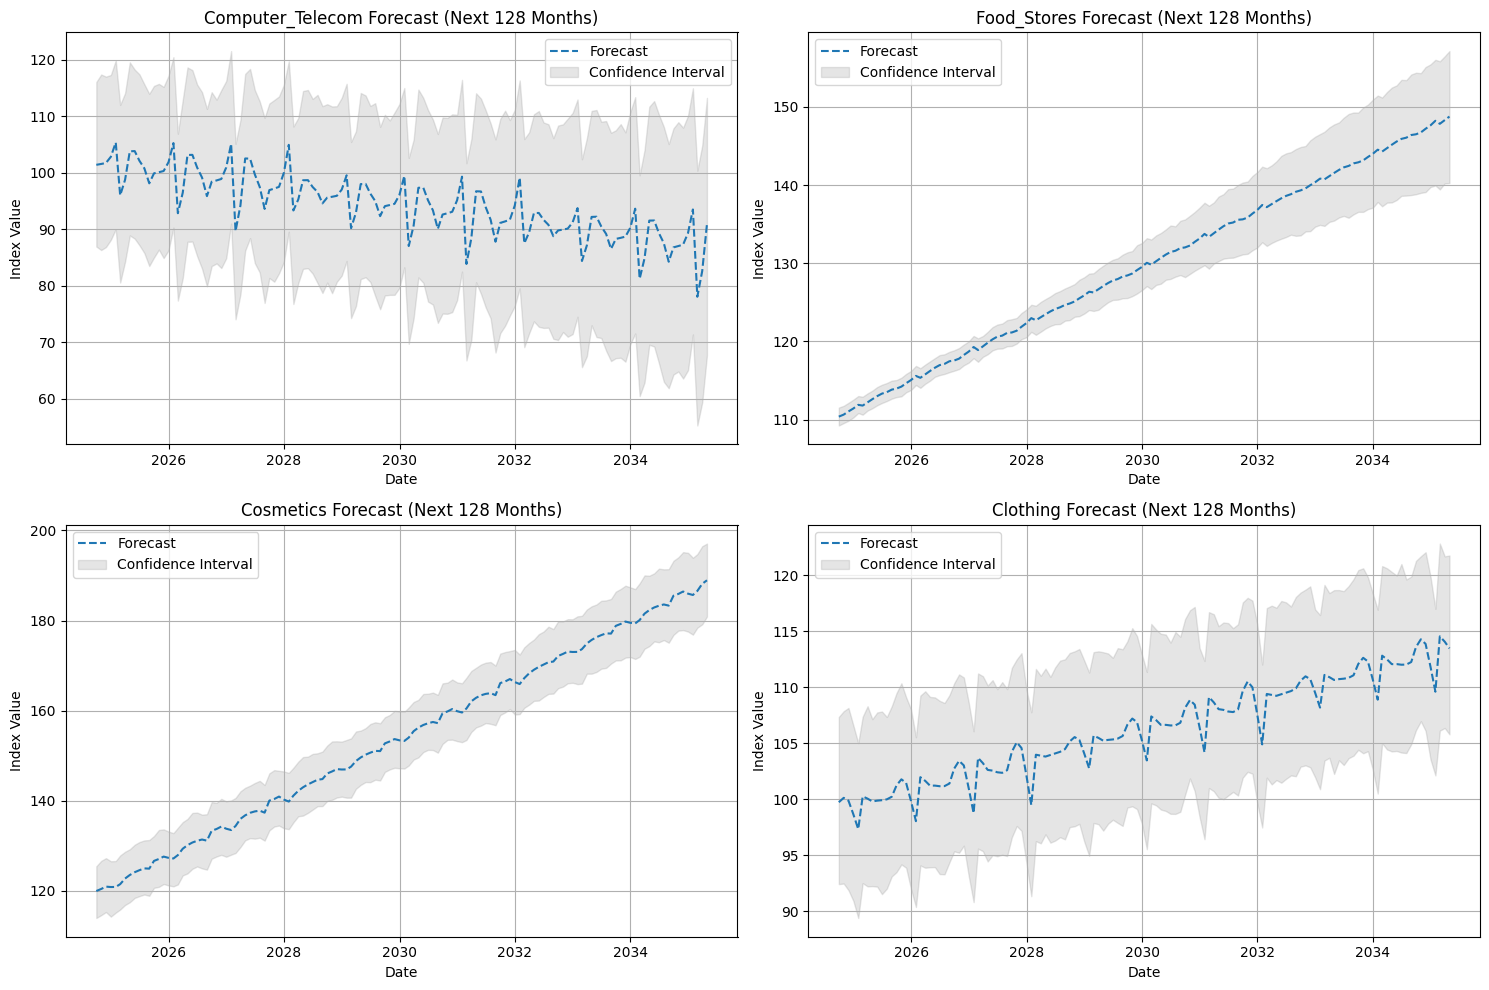

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forecast_periods = 128  # 128 months (a little more than 10 years)

plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()

    # Inverse log transform to go back to original scale
    series_original = np.expm1(series)

    # Prophet input format
    df_prophet = pd.DataFrame({
        'ds': series_original.index,
        'y': series_original.values
    })

    # Initialize Prophet
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_prophet)

    # Future dates for 128 months
    future = model.make_future_dataframe(periods=forecast_periods, freq='M')
    forecast = model.predict(future)

    # Only take the future forecast (excluding training period)
    forecast_future = forecast.tail(forecast_periods)

    # Plot
    plt.subplot(2, 2, i + 1)
    plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Forecast', linestyle='--')
    plt.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    plt.title(f"{column} Forecast (Next 128 Months)", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Index Value")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4268erw6/t3253jpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4268erw6/mbx9knsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15540', 'data', 'file=/tmp/tmp4268erw6/t3253jpq.json', 'init=/tmp/tmp4268erw6/mbx9knsi.json', 'output', 'file=/tmp/tmp4268erw6/prophet_modelca0s_hg8/prophet_model-20250427200518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:05:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:05:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4268erw6/a6n24zka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4268erw6/q7eospq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

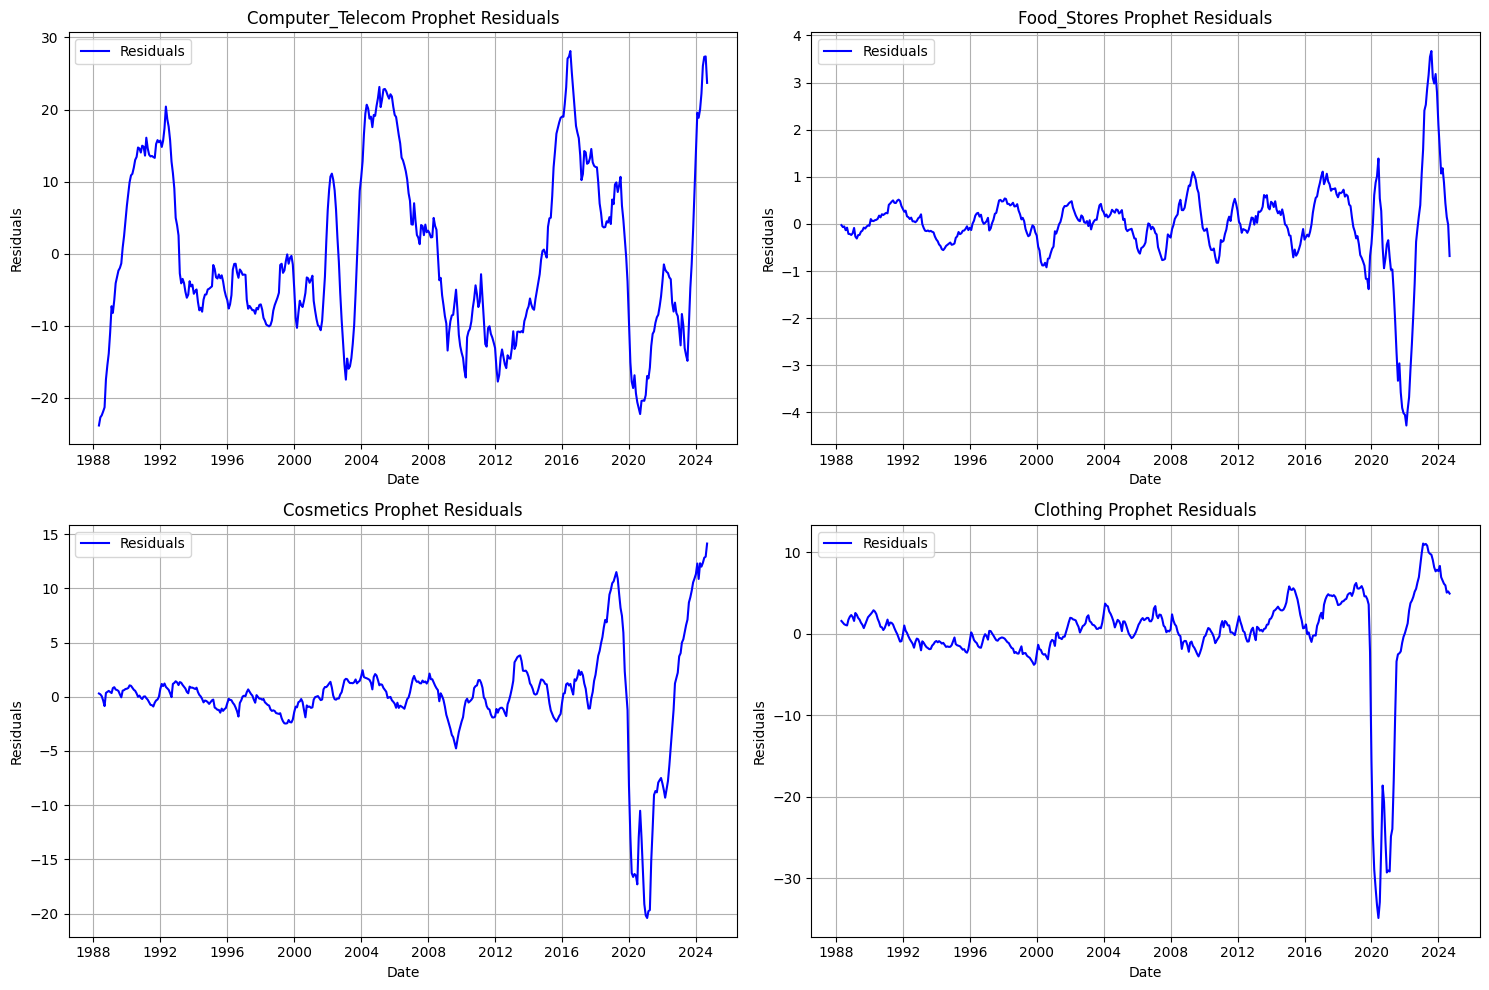

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()

    # Inverse log transform for Prophet (model works on original scale)
    series_original = np.expm1(series)

    # Prophet requires two columns: ds (date), y (value)
    df_prophet = pd.DataFrame({
        'ds': series_original.index,
        'y': series_original.values
    })

    # Initialize Prophet with yearly seasonality
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_prophet)

    # Predict on the historical data to get fitted values
    forecast = model.predict(df_prophet)

    # Calculate residuals (observed - fitted)
    residuals = df_prophet['y'] - forecast['yhat']

    # Plot residuals
    plt.subplot(2, 2, i + 1)
    plt.plot(df_prophet['ds'], residuals, label='Residuals', color='blue')
    plt.title(f"{column} Prophet Residuals", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Residuals Analysis (2018-2025)

The graph displays residuals over time from 2018 to 2025. Residuals represent the difference between observed and predicted values in a model, with larger residuals indicating poorer model fit.

### Observations

1. **Significant Dip in 2020-2021**  
   - Residuals drop sharply to approximately -40 in 2020.  
   - This indicates a major deviation from the expected trend, likely due to an external event (e.g., the COVID-19 pandemic).  
   - The model fails to capture this anomaly, resulting in large negative residuals.

2. **Recovery in 2021-2022**  
   - After the 2020 dip, residuals recover rapidly, returning to near zero by 2022.  
   - This suggests the system or data returns to the expected pattern, and the model regains accuracy.

3. **Fluctuations Near Zero**  
   - From 2018 to 2019 and 2022 to 2025, residuals fluctuate around zero, with minor deviations (typically between -10 and +10).  
   - This indicates the model generally fits well during these periods, though minor inconsistencies exist.

### Conclusion

- The model struggles significantly around 2020-2021, likely due to an external shock, but performs reasonably well otherwise.  

# ARIMA Model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be

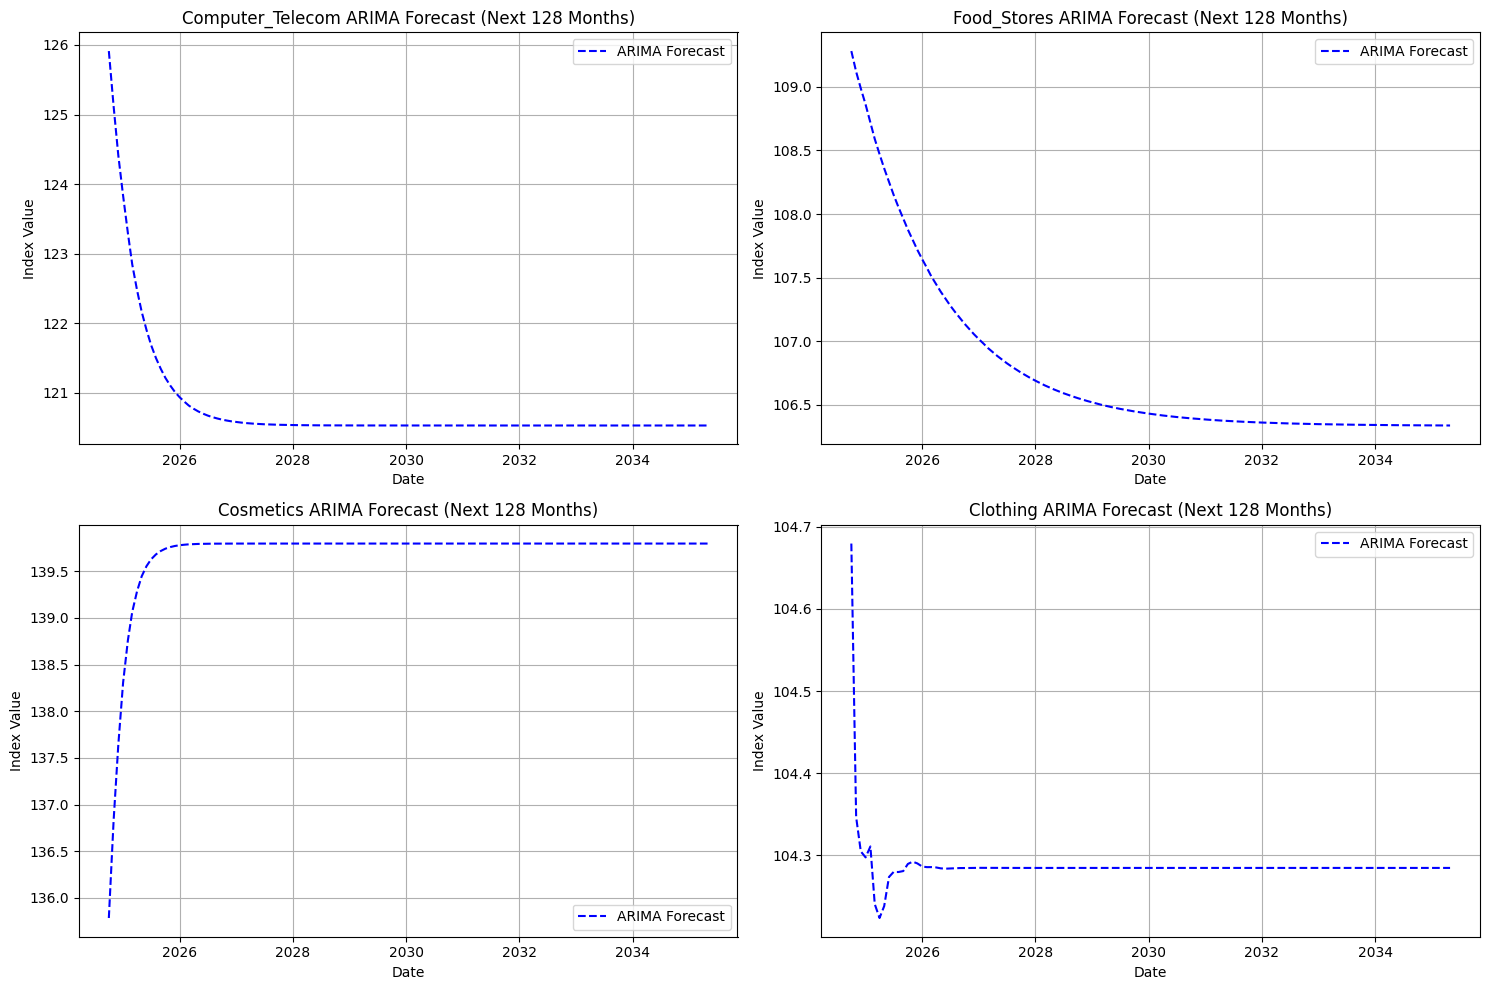

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()
    series_original = np.expm1(series)  # Inverse log transform to original scale

    try:
        from statsmodels.tsa.arima.model import ARIMA
        model_arima = ARIMA(series_original, order=(5, 1, 0))  # Simple ARIMA(p,d,q)
        arima_fit = model_arima.fit()
        arima_forecast = arima_fit.forecast(steps=forecast_periods)  # 128 steps into the future
        future_dates = generate_future_dates(series_original.index[-1], forecast_periods)

        # Plot only the forecast
        plt.subplot(2, 2, i + 1)
        plt.plot(future_dates, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
        plt.title(f"{column} ARIMA Forecast (Next 128 Months)", fontsize=12)
        plt.xlabel("Date")
        plt.ylabel("Index Value")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"ARIMA failed for {column}: {e}")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

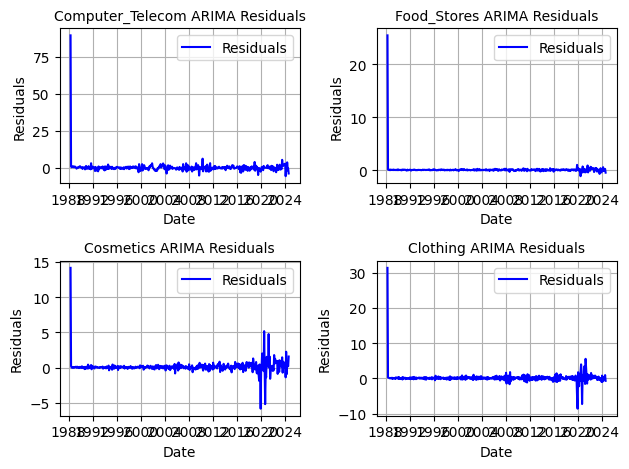

In [ ]:
for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()
    series_original = np.expm1(series)  # Inverse log transform to original scale

    try:
        # Fit ARIMA model
        model_arima = ARIMA(series_original, order=(5, 1, 0))  # ARIMA(p,d,q)
        arima_fit = model_arima.fit()

        # Get fitted values (in-sample predictions)
        fitted_values = arima_fit.fittedvalues

        # Calculate residuals (observed - fitted)
        residuals = series_original - fitted_values

        # Plot residuals
        plt.subplot(2, 2, i + 1)
        plt.plot(series_original.index, residuals, label='Residuals', color='blue')
        plt.title(f"{column} ARIMA Residuals", fontsize=10)
        plt.xlabel("Date")
        plt.ylabel("Residuals")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"ARIMA failed for {column}: {e}")

plt.tight_layout()

## ARIMA Residuals Analysis for Multiple Sectors (1988-2024)

The provided plots display the residuals of an ARIMA(5,1,0) model applied to four different sectors—Computer & Telecom, Food Stores, Cosmetics, and Clothing—over the period from 1988 to 2024. Residuals represent the difference between observed and fitted values, with larger residuals indicating poorer model fit.

### Observations

#### 1. Computer & Telecom ARIMA Residuals
- **General Trend**: Residuals mostly fluctuate around zero from 1988 to 2020, with occasional spikes.
- **Significant Spike**: Around 2020, residuals spike dramatically to around 75, indicating a major deviation from the model's predictions.
  - This could be due to an external event (e.g., the COVID-19 pandemic) impacting the sector, which the ARIMA model fails to capture.
- **Post-2020**: Residuals return to near zero, suggesting the model regains accuracy as the sector stabilizes.

#### 2. Food Stores ARIMA Residuals
- **General Trend**: Residuals are relatively stable, fluctuating around zero for most of the period (1988-2020).
- **Spike in 2020**: A noticeable spike occurs around 2020, reaching approximately 20.
  - This indicates the model underestimates the observed values, likely due to a sudden change in consumer behavior (e.g., panic buying during the pandemic).
- **Post-2020**: Residuals decrease and stabilize near zero, indicating a return to predictable patterns.

#### 3. Cosmetics ARIMA Residuals
- **General Trend**: Residuals are mostly small and fluctuate around zero from 1988 to 2020.
- **Spike in 2020**: A significant spike occurs around 2020, with residuals reaching around 15.
  - This suggests the model fails to account for an abrupt change, possibly due to reduced demand for cosmetics during lockdowns.
- **Post-2020**: Residuals return to near zero, showing the model fits well again after the anomaly.

#### 4. Clothing ARIMA Residuals
- **General Trend**: Residuals are generally close to zero from 1988 to 2020, with minor fluctuations.
- **Spike in 2020**: A large spike occurs around 2020, with residuals peaking at around 30, followed by a sharp drop to -10.
  - This indicates the model significantly underestimates and then overestimates the observed values, likely due to volatile demand in the clothing sector during the pandemic.
- **Post-2020**: Residuals stabilize near zero, indicating the model regains accuracy.

### Model Performance Insights

- **Common Pattern Across Sectors**: All sectors show a significant residual spike around 2020, likely due to the global impact of the COVID-19 pandemic. The ARIMA(5,1,0) model struggles to handle such abrupt external shocks.
- **Strengths**: The model performs well during stable periods (1988-2019 and 2021-2024), as residuals are generally close to zero, indicating a good fit.
- **Weaknesses**: The model fails to capture the 2020 anomaly across all sectors, with the largest residuals in Computer & Telecom (75) and the smallest in Cosmetics (15). This suggests the model is not robust to sudden, large disruptions.
- **Sector-Specific Insights**:
  - **Computer & Telecom**: Most affected by the 2020 event, possibly due to a surge in demand for tech products during remote work shifts.
  - **Food Stores**: Moderate residuals, reflecting relatively stable demand with temporary disruptions.
  - **Cosmetics and Clothing**: Both show significant but smaller residuals, likely due to reduced demand during lockdowns, with Clothing showing more volatility post-2020.

### Conclusion

- The ARIMA(5,1,0) model fits well during stable periods but fails to handle the 2020 anomaly across all sectors.

# SARIMA Model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be

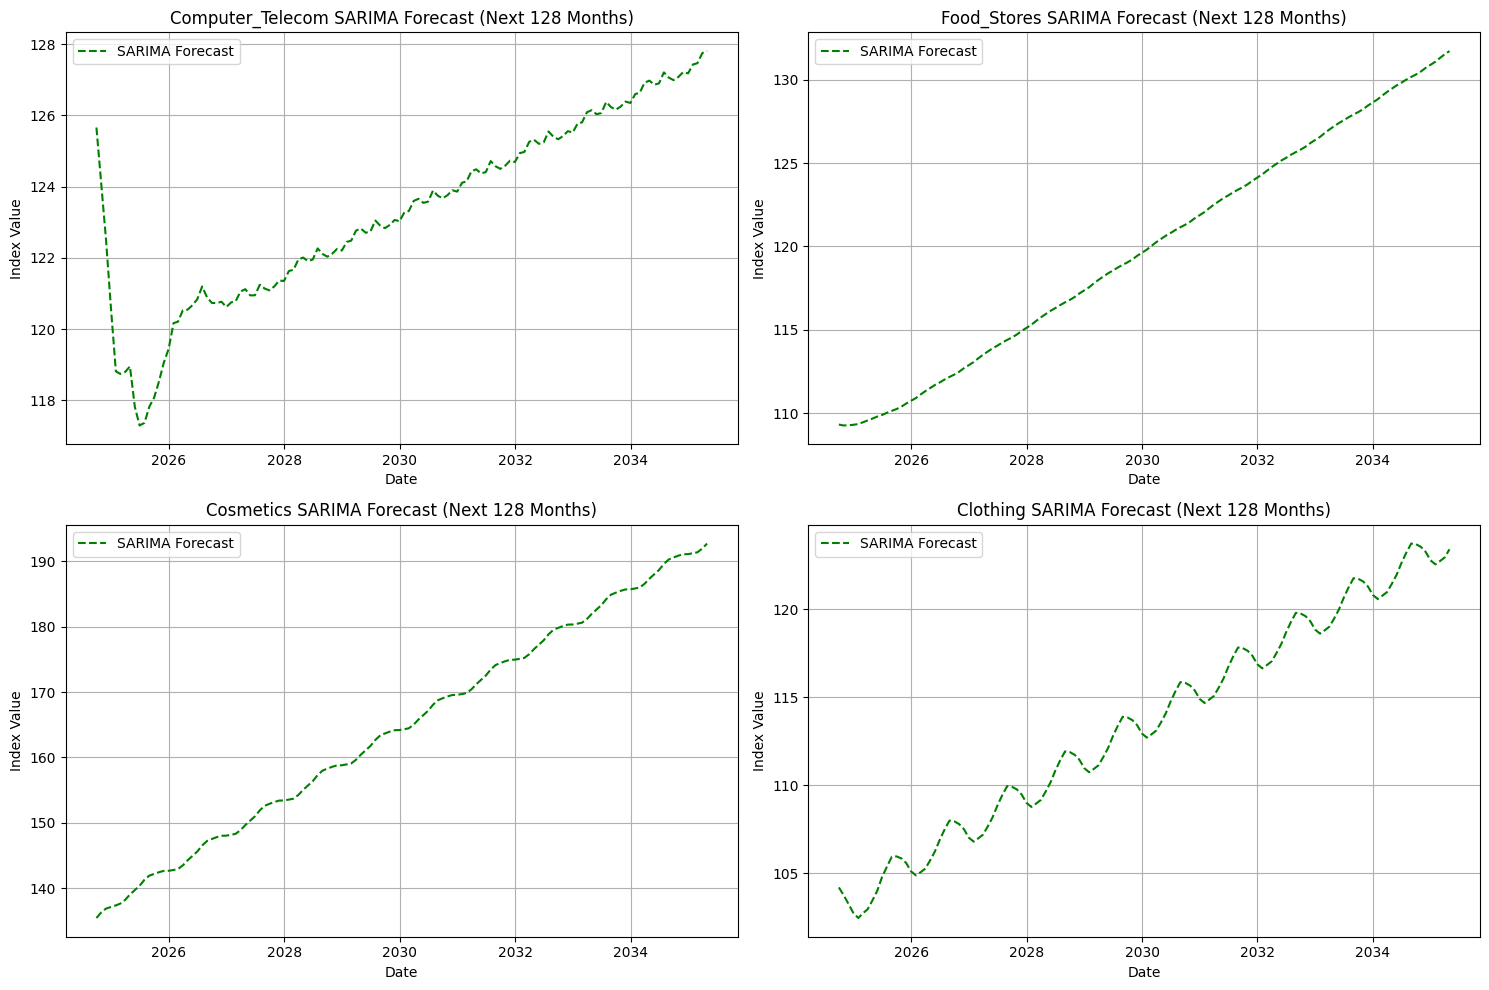

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()
    series_original = np.expm1(series)  # Inverse log transform to original scale

    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model_sarima = SARIMAX(series_original, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = model_sarima.fit(disp=False)
        sarima_forecast = sarima_fit.forecast(steps=forecast_periods)
        future_dates = generate_future_dates(series_original.index[-1], forecast_periods)

        # Plot only the forecast
        plt.subplot(2, 2, i + 1)
        plt.plot(future_dates, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='green')
        plt.title(f"{column} SARIMA Forecast (Next 128 Months)", fontsize=12)
        plt.xlabel("Date")
        plt.ylabel("Index Value")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"SARIMA failed for {column}: {e}")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

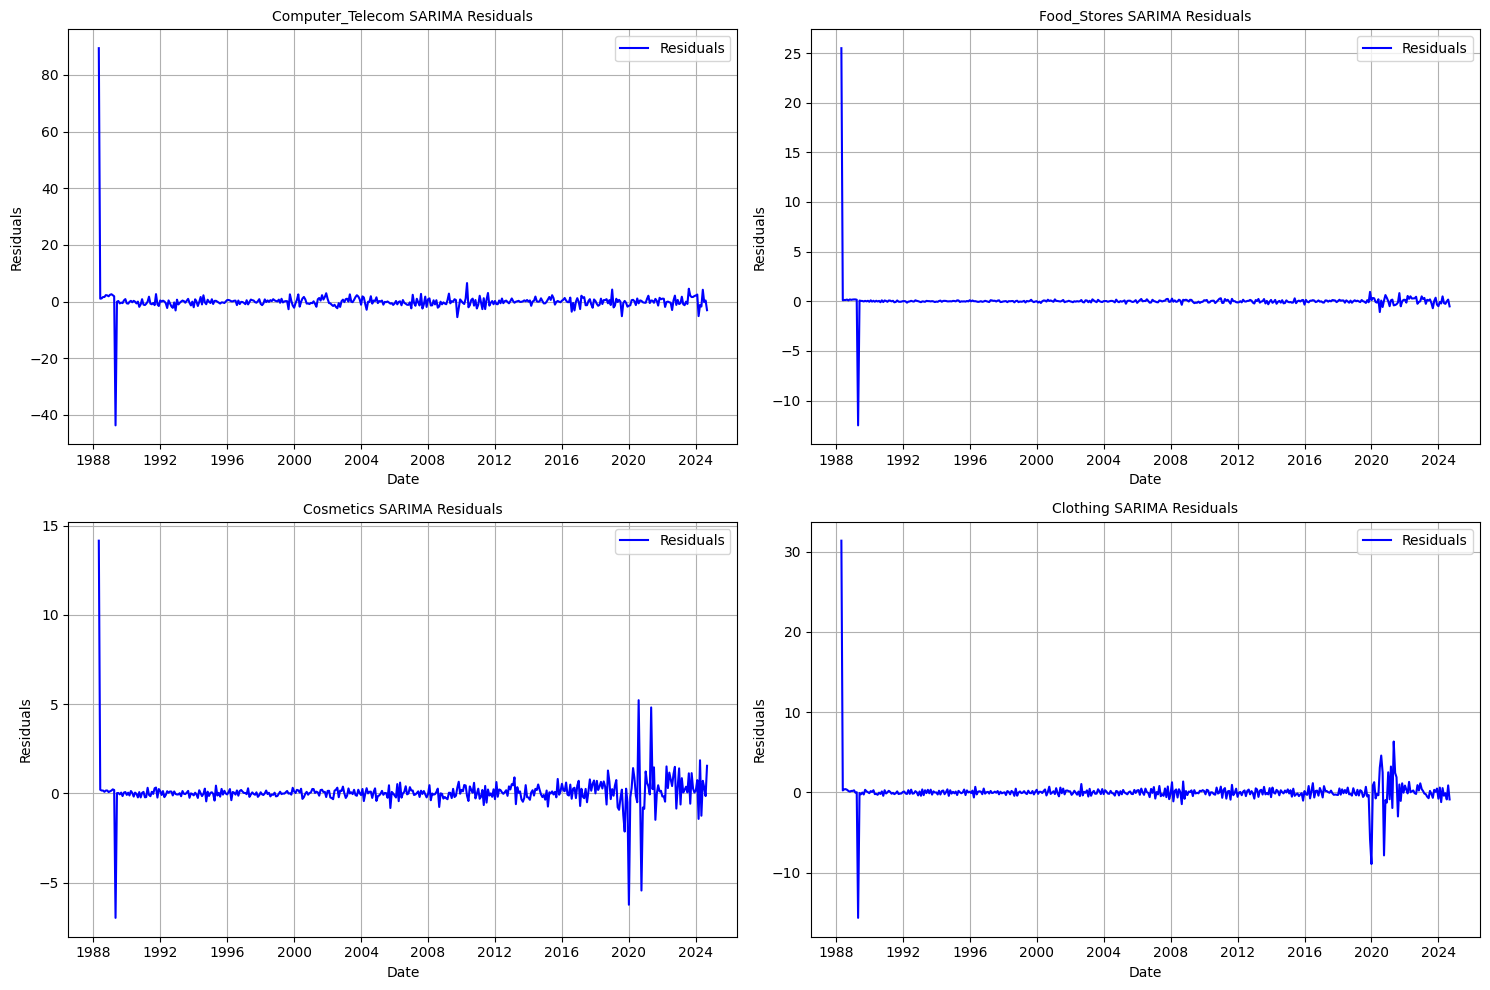

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()
    series_original = np.expm1(series)  # Inverse log transform to original scale

    try:
        # Fit SARIMA model
        model_sarima = SARIMAX(series_original, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = model_sarima.fit(disp=False)

        # Get fitted values (in-sample predictions)
        fitted_values = sarima_fit.fittedvalues

        # Calculate residuals (observed - fitted)
        residuals = series_original - fitted_values

        # Plot residuals
        plt.subplot(2, 2, i + 1)
        plt.plot(series_original.index, residuals, label='Residuals', color='blue')
        plt.title(f"{column} SARIMA Residuals", fontsize=10)
        plt.xlabel("Date")
        plt.ylabel("Residuals")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"SARIMA failed for {column}: {e}")

plt.tight_layout()
plt.show()

# Analysis of SARIMA Residuals for Industry Forecasts

The following analysis examines the residuals from the SARIMA model for four industries: Computer/Telecom, Food Stores, Cosmetics, and Clothing. Residuals represent the difference between observed and predicted values, with smaller residuals indicating a better model fit. The plots show residuals over time from 1988 to 2024.

## Computer/Telecom SARIMA Residuals
- **Magnitude**: Residuals range from -20 to 80, with a significant spike to -20 around 1988 and smaller fluctuations (mostly within ±5) after 1990.
- **Pattern**: The large negative spike at the start suggests the model initially overpredicted the index value. After 1990, residuals stabilize, indicating a better fit, though minor fluctuations persist.
- **Implication**: The early spike shows SARIMA struggled with the initial data, possibly due to a structural shift or volatility in the Computer/Telecom industry. Post-1990, the model fits well, with residuals mostly near zero.

## Food Stores SARIMA Residuals
- **Magnitude**: Residuals range from -10 to 20, with a large spike to -10 around 1988 and smaller variations (within ±2) after 1990.
- **Pattern**: Similar to Computer/Telecom, a significant negative spike occurs at the start, followed by stable residuals close to zero, with minor spikes around 2023-2024.
- **Implication**: The early spike indicates an initial overprediction, but the model fits well afterward, as residuals remain small. The recent spikes suggest minor mispredictions during recent changes in the Food Stores industry.

## Cosmetics SARIMA Residuals
- **Magnitude**: Residuals range from -5 to 15, with a large spike to -5 around 1988 and another to 10 around 2015-2016.
- **Pattern**: After the initial spike, residuals are small (within ±2) until around 2010, where they start to fluctuate more, peaking during 2015-2016, then stabilizing again.
- **Implication**: The early spike shows an initial overprediction, but the model fits well until 2010. The 2015-2016 spike suggests SARIMA struggled with a period of rapid change in the Cosmetics industry, possibly due to a trend shift.

## Clothing SARIMA Residuals
- **Magnitude**: Residuals range from -10 to 20, with a large spike to -10 around 1988 and another to 20 around 2023.
- **Pattern**: After the initial spike, residuals are small (within ±2) until a significant spike in 2023, indicating a large prediction error during that period.
- **Implication**: The early spike shows an initial overprediction, but the model fits well for most of the period. The 2023 spike corresponds to a sharp drop in the Clothing industry (as seen in prior forecasts), which SARIMA failed to capture accurately.

## Overall Insights
- **Common Pattern**: All industries show a large negative residual spike around 1988, suggesting SARIMA consistently overpredicted at the start, possibly due to limited historical data or a structural break in the early years.
- **Fit Quality**: After 1990, SARIMA generally fits well across all industries, with residuals mostly within ±2, except during specific periods of change (e.g., 2015-2016 for Cosmetics, 2023 for Clothing).
- **Weaknesses**: SARIMA struggles with sudden changes or volatility, as seen in the 2023 Clothing spike and 2015-2016 Cosmetics fluctuations. This indicates the model may not adapt quickly to abrupt shifts.
- **Strengths**: For stable periods, SARIMA provides a good fit, with residuals close to zero, making it reliable for industries with gradual trends (e.g., Food Stores post-1990).

# ETS (Exponential Smoothing)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so infer

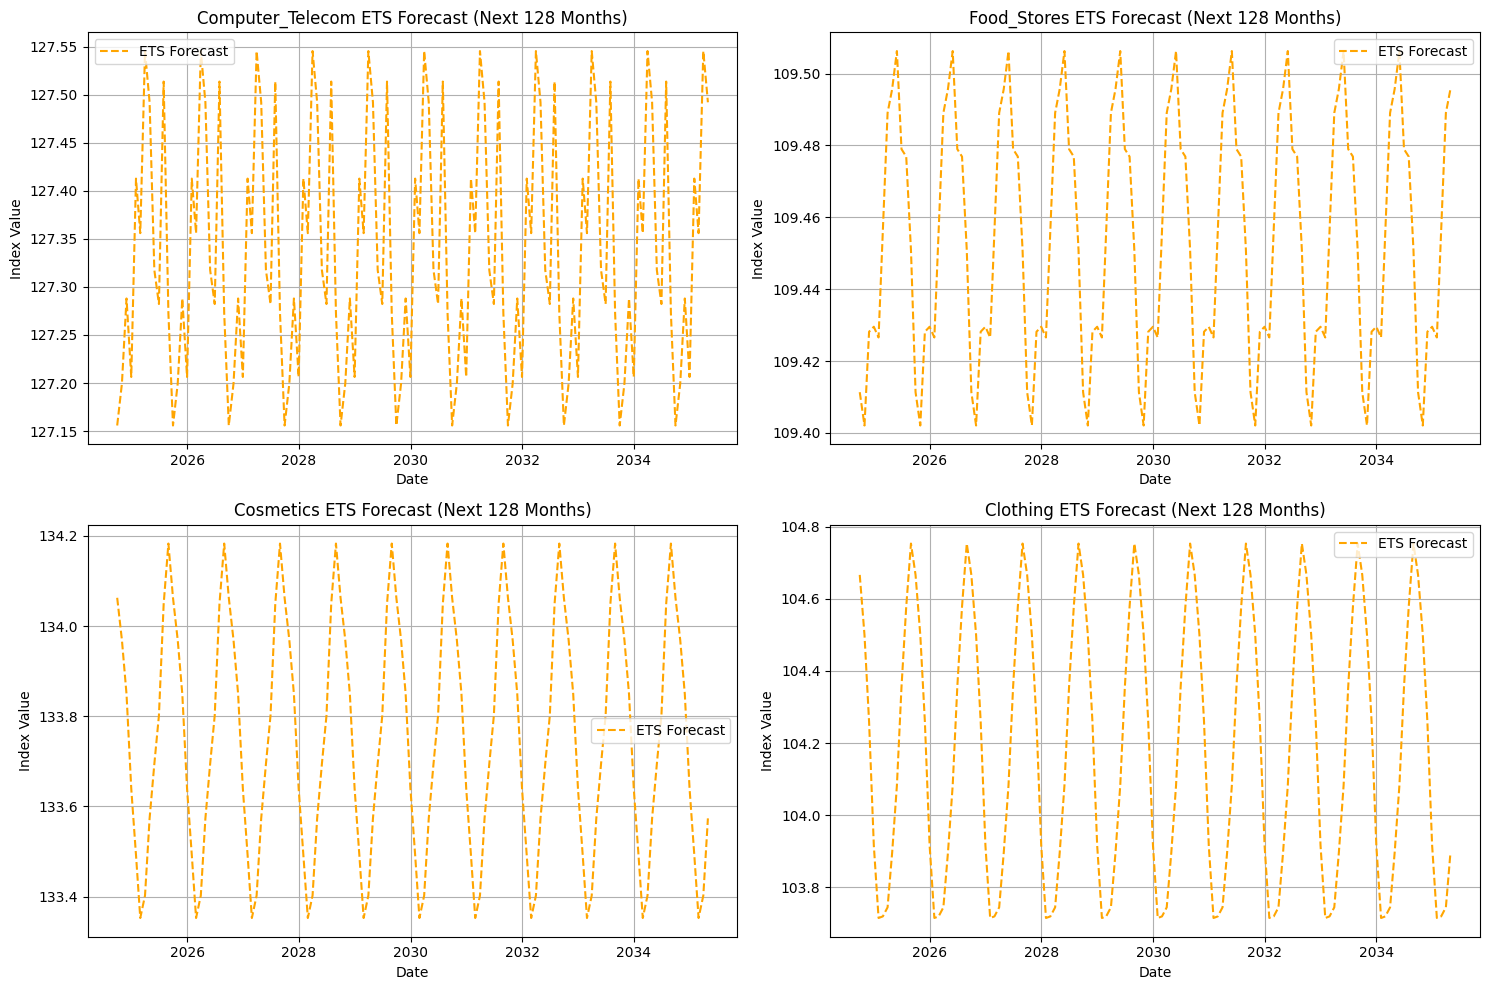

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()
    series_original = np.expm1(series)  # Inverse log transform to original scale

    try:
        from statsmodels.tsa.holtwinters import ExponentialSmoothing
        model_ets = ExponentialSmoothing(series_original, seasonal='add', seasonal_periods=12)
        ets_fit = model_ets.fit()
        ets_forecast = ets_fit.forecast(steps=forecast_periods)
        future_dates = generate_future_dates(series_original.index[-1], forecast_periods)

        # Plot only the forecast
        plt.subplot(2, 2, i + 1)
        plt.plot(future_dates, ets_forecast, label='ETS Forecast', linestyle='--', color='orange')
        plt.title(f"{column} ETS Forecast (Next 128 Months)", fontsize=12)
        plt.xlabel("Date")
        plt.ylabel("Index Value")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"ETS failed for {column}: {e}")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


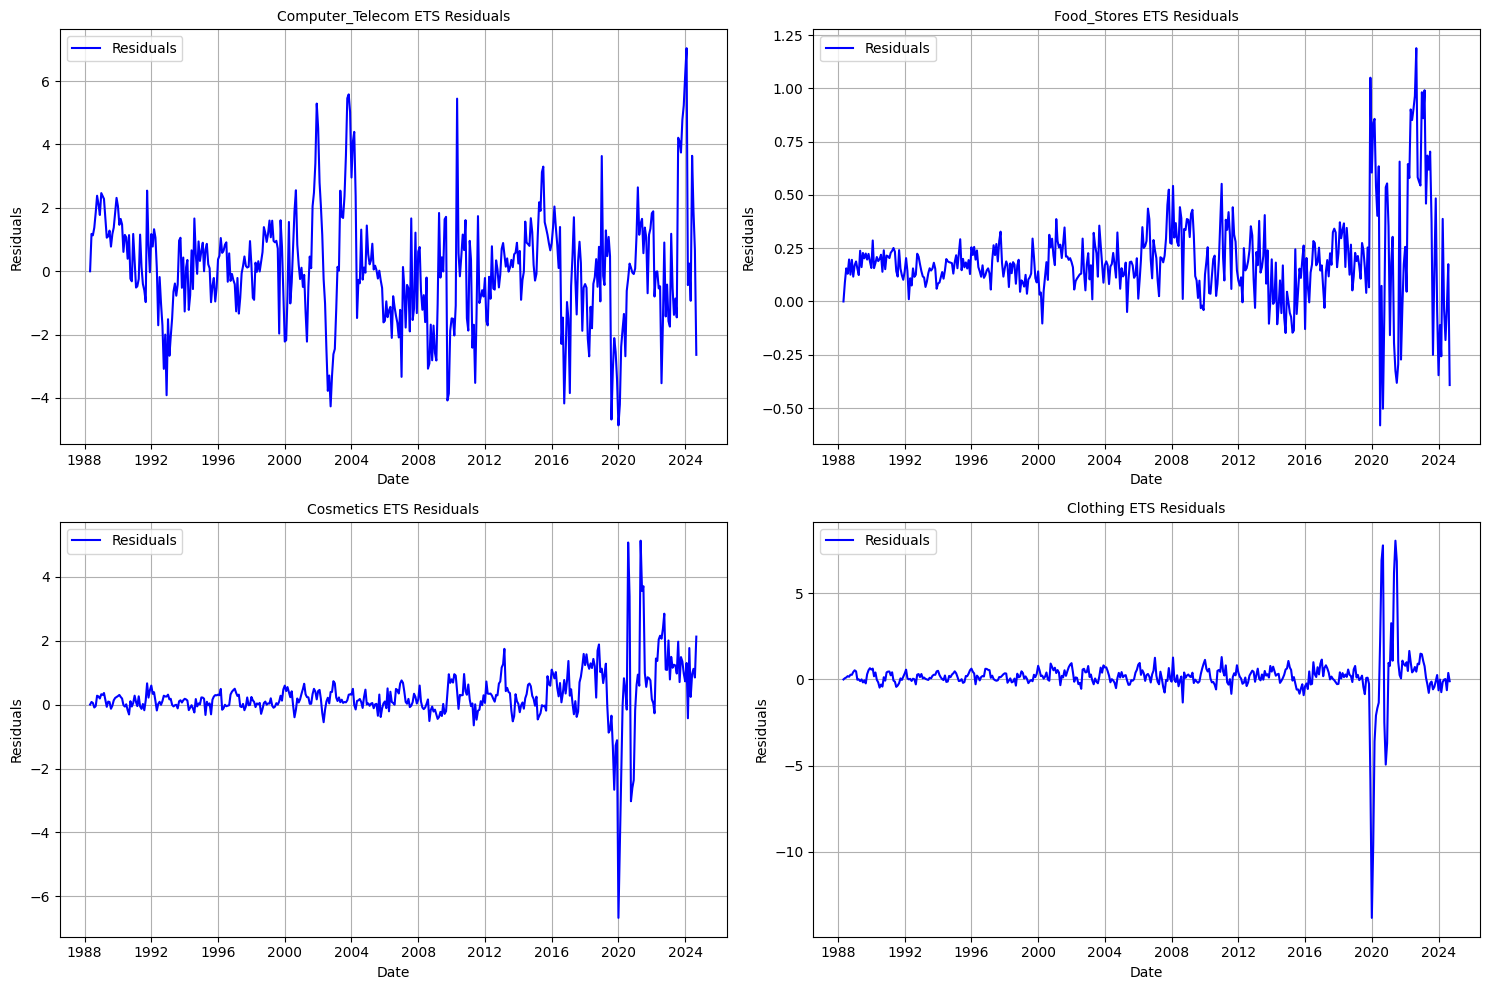

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()
    series_original = np.expm1(series)  # Inverse log transform to original scale

    try:
        # Fit ETS model
        model_ets = ExponentialSmoothing(series_original, seasonal='add', seasonal_periods=12)
        ets_fit = model_ets.fit()

        # Get fitted values (in-sample predictions)
        fitted_values = ets_fit.fittedvalues

        # Calculate residuals (observed - fitted)
        residuals = series_original - fitted_values

        # Plot residuals
        plt.subplot(2, 2, i + 1)
        plt.plot(series_original.index, residuals, label='Residuals', color='blue')
        plt.title(f"{column} ETS Residuals", fontsize=10)
        plt.xlabel("Date")
        plt.ylabel("Residuals")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"ETS failed for {column}: {e}")

plt.tight_layout()

## ETS Residuals Analysis for Multiple Sectors (1988-2024)

The provided plots display the residuals of an Exponential Smoothing (ETS) model with additive seasonality (seasonal period of 12 months) applied to four different sectors—Computer & Telecom, Food Stores, Cosmetics, and Clothing—over the period from 1988 to 2024. Residuals represent the difference between observed and fitted values, with larger residuals indicating poorer model fit.

### Observations

#### 1. Computer & Telecom ETS Residuals
- **General Trend**: Residuals fluctuate around zero from 1988 to 2020, with occasional spikes.
- **Significant Spikes**: Multiple large spikes occur, notably around 1996 (residual ~6), 2012 (~5), and 2020 (~6).
  - These spikes indicate periods where the ETS model fails to capture sudden changes, possibly due to economic events, technological shifts, or the COVID-19 pandemic in 2020.
- **Post-2020**: Residuals remain volatile but return to smaller fluctuations, suggesting the model struggles with long-term stability in this sector.

#### 2. Food Stores ETS Residuals
- **General Trend**: Residuals are relatively stable, fluctuating around zero with smaller amplitudes (±0.5) from 1988 to 2020.
- **Spike in 2020**: A significant spike occurs around 2020, reaching approximately 1.25.
  - This indicates the model underestimates the observed values, likely due to sudden changes in consumer behavior (e.g., panic buying during the pandemic).
- **Post-2020**: Residuals remain volatile, with fluctuations increasing in amplitude, suggesting the model struggles to adapt to post-2020 dynamics.

#### 3. Cosmetics ETS Residuals
- **General Trend**: Residuals fluctuate around zero from 1988 to 2020, with moderate variability (±2).
- **Spike in 2020**: A large negative spike occurs around 2020, with residuals dropping to around -5.
  - This suggests the model overestimates the observed values, possibly due to a sharp decline in demand for cosmetics during lockdowns.
- **Post-2020**: Residuals return to smaller fluctuations, indicating the model regains accuracy after the anomaly.

#### 4. Clothing ETS Residuals
- **General Trend**: Residuals are mostly stable around zero from 1988 to 2020, with small fluctuations (±2).
- **Spike in 2020**: A significant negative spike occurs around 2020, with residuals dropping to around -10.
  - This indicates the model overestimates the observed values, likely due to reduced demand for clothing during the pandemic.
- **Post-2020**: Residuals show a sharp positive spike immediately after 2020 (reaching ~5), suggesting a rebound the model underestimates, followed by smaller fluctuations.

### Model Performance Insights

- **Common Pattern Across Sectors**: All sectors show significant residual spikes around 2020, likely due to the global impact of the COVID-19 pandemic. The ETS model struggles to handle such abrupt external shocks.
- **Strengths**: The model performs reasonably well during stable periods (1988-2019), with residuals generally close to zero, indicating a good fit for capturing trends and seasonality.
- **Weaknesses**: The model fails to capture the 2020 anomaly across all sectors, with the largest residuals in Clothing (-10) and the smallest in Food Stores (1.25). Additionally, Computer & Telecom shows recurring large residuals, indicating poor fit for this sector.
- **Sector-Specific Insights**:
  - **Computer & Telecom**: High volatility in residuals suggests the ETS model is not well-suited for this sector, possibly due to rapid technological changes and economic shifts.
  - **Food Stores**: Smaller residuals indicate more stable demand patterns, but the model still struggles post-2020.
  - **Cosmetics and Clothing**: Both show significant negative residuals in 2020, reflecting reduced demand during the pandemic, with Clothing showing a more pronounced rebound effect.

### Conclusion

- The ETS model with additive seasonality fits well during stable periods but fails to handle the 2020 anomaly across all sectors, particularly in Computer & Telecom and Clothing.

# LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-58-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-58-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), 

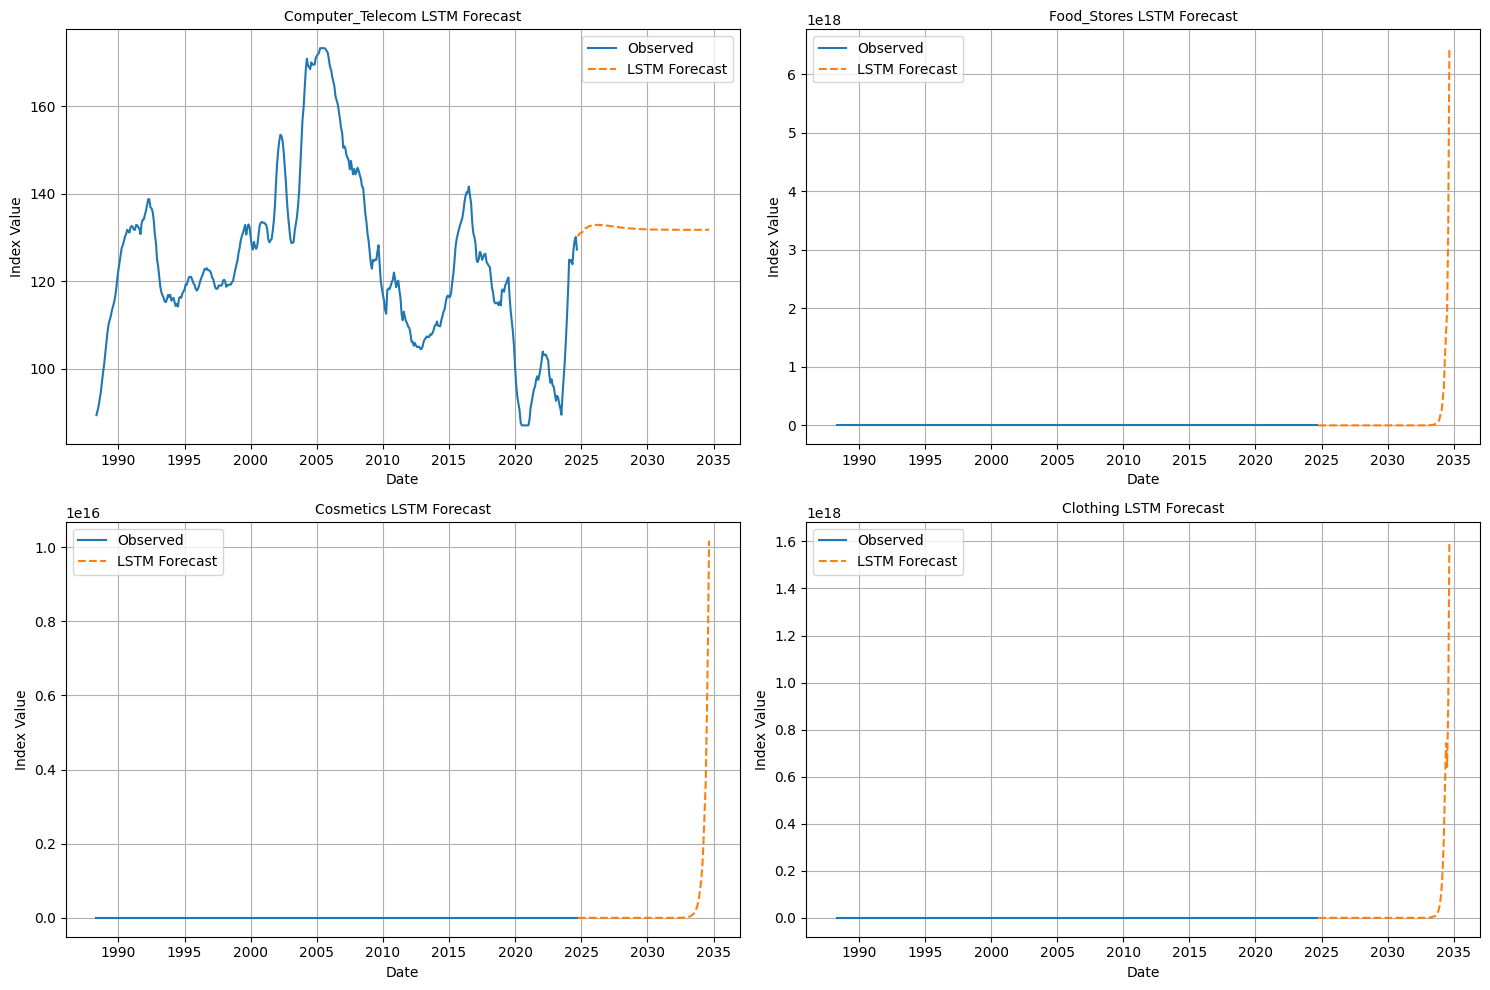

In [ ]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_smooth.columns):
    series = df_smooth[column].dropna()
    series_original = np.expm1(series)  # Inverse log transform to original scale

    try:
        from sklearn.preprocessing import MinMaxScaler
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense

        # Prepare data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(series_original.values.reshape(-1, 1))

        # Create sequences
        def create_sequences(data, seq_length):
            X, y = [], []
            for j in range(len(data) - seq_length):
                X.append(data[j:j+seq_length])
                y.append(data[j+seq_length])
            return np.array(X), np.array(y)

        seq_length = 12
        X, y = create_sequences(scaled_data, seq_length)

        # Split into train/test
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Build LSTM
        model_lstm = Sequential()
        model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
        model_lstm.add(Dense(1))
        model_lstm.compile(optimizer='adam', loss='mse')

        # Reshape for LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Forecast
        last_sequence = scaled_data[-seq_length:].reshape((1, seq_length, 1))
        lstm_forecast = []
        for _ in range(forecast_periods):
            pred = model_lstm.predict(last_sequence, verbose=0)
            lstm_forecast.append(pred[0, 0])
            last_sequence = np.roll(last_sequence, -1, axis=1)
            last_sequence[0, -1, 0] = pred[0, 0]

        lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()
        future_dates = generate_future_dates(series_original.index[-1], forecast_periods)

        # Plot
        plt.subplot(2, 2, i + 1)
        plt.plot(series_original.index, series_original, label='Observed')
        plt.plot(future_dates, lstm_forecast, label='LSTM Forecast', linestyle='--')
        plt.title(f"{column} LSTM Forecast", fontsize=10)
        plt.xlabel("Date")
        plt.ylabel("Index Value")
        plt.grid(True)
        plt.legend()
    except Exception as e:
        print(f"LSTM failed for {column}: {e}")

plt.tight_layout()
plt.show()

# XGBoost Model

<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)
<ipython-input-4-4add73af6b0e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start=start_date + pd.offsets.MonthEnd(1), periods=periods, freq=freq)


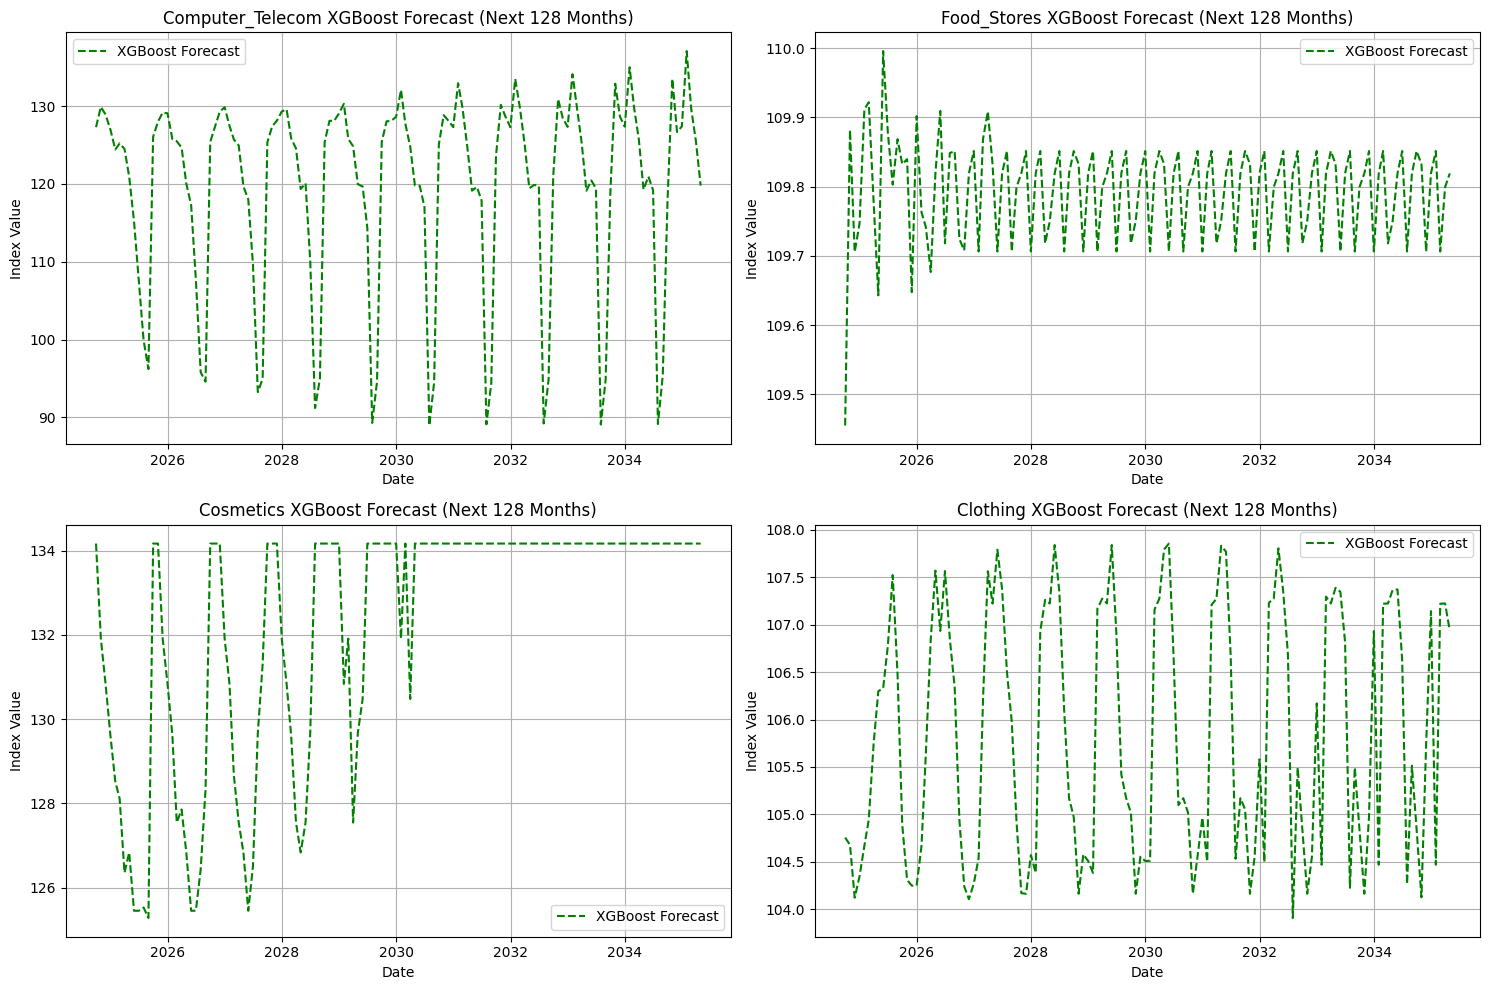

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    try:
        series = df_smooth[column].dropna()
        series_original = np.expm1(series)  # Inverse log transform

        # Prepare data with lagged features
        def create_lagged_features(data, lags=12):
            df = pd.DataFrame(data, index=data.index)
            for lag in range(1, lags + 1):
                df[f'lag_{lag}'] = df.iloc[:, 0].shift(lag)
            return df.dropna()

        xgb_data = create_lagged_features(series_original)
        X_xgb = xgb_data.drop(columns=series_original.name if series_original.name else xgb_data.columns[0])
        y_xgb = xgb_data.iloc[:, 0]

        # Train XGBoost
        model_xgb = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
        model_xgb.fit(X_xgb, y_xgb)

        # Forecast iteratively
        xgb_forecast = []
        last_values = X_xgb.iloc[-1].values.copy()
        for _ in range(forecast_periods):
            pred = model_xgb.predict(last_values.reshape(1, -1))[0]
            xgb_forecast.append(pred)
            last_values = np.roll(last_values, -1)
            last_values[-1] = pred

        future_dates = generate_future_dates(series_original.index[-1], forecast_periods)

        # Plot only the forecast
        plt.subplot(2, 2, i + 1)
        plt.plot(future_dates, xgb_forecast, label='XGBoost Forecast', linestyle='--', color='green')
        plt.title(f"{column} XGBoost Forecast (Next 128 Months)", fontsize=12)
        plt.xlabel("Date")
        plt.ylabel("Index Value")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"XGBoost failed for {column}: {e}")

plt.tight_layout()
plt.show()


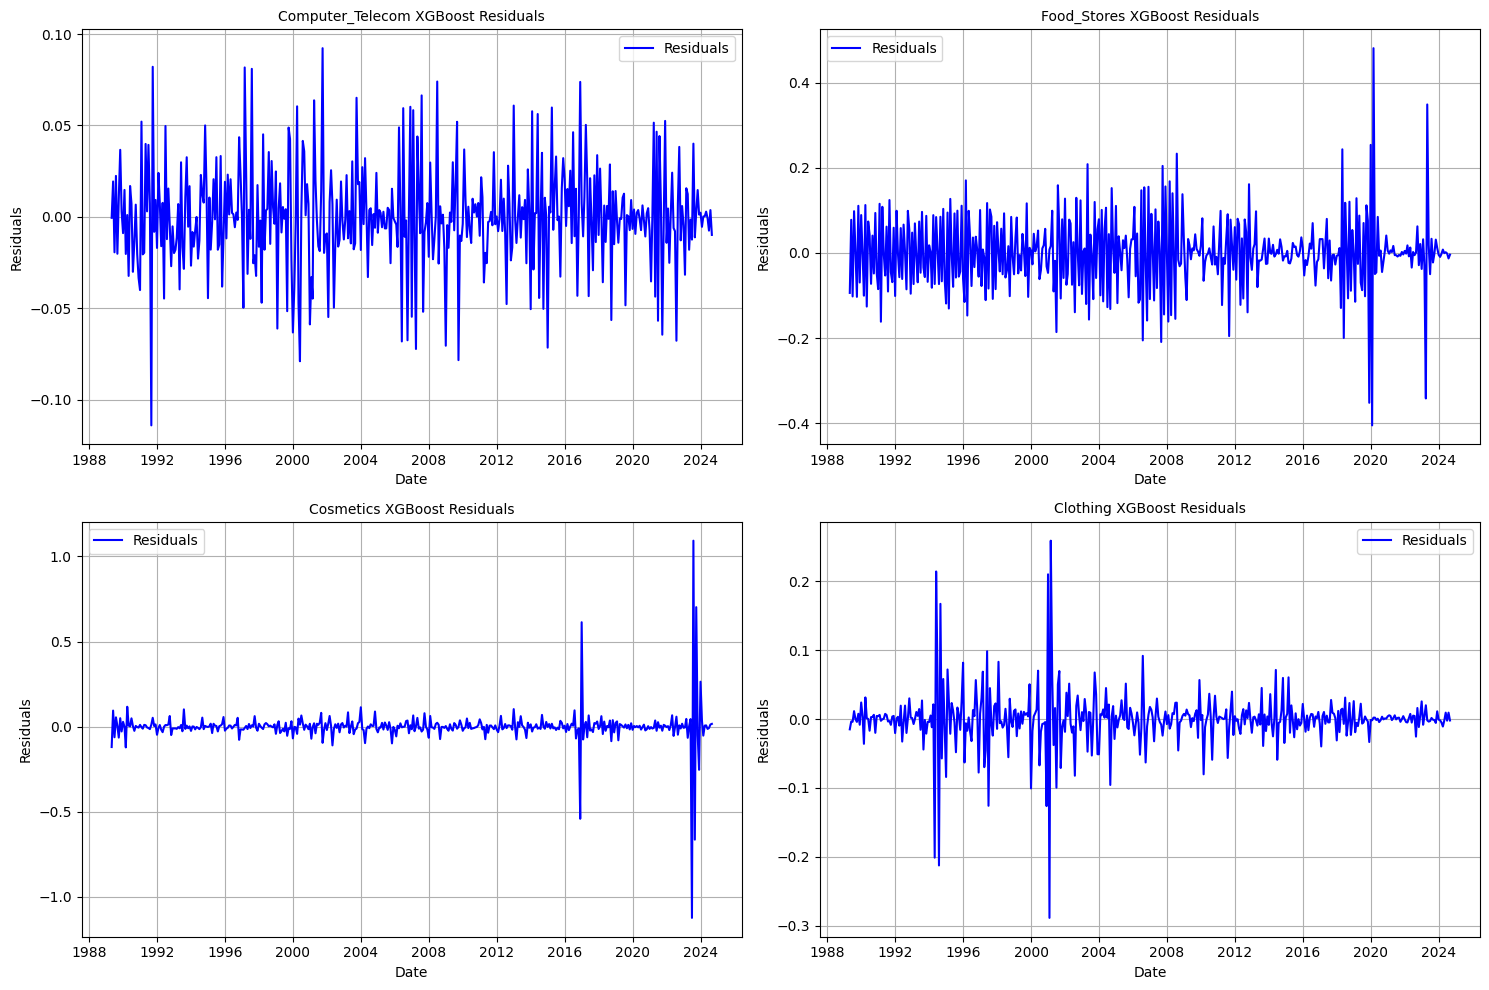

In [ ]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_smooth.columns):
    try:
        series = df_smooth[column].dropna()
        series_original = np.expm1(series)  # Inverse log transform

        # Prepare data with lagged features
        def create_lagged_features(data, lags=12):
            df = pd.DataFrame(data, index=data.index)
            for lag in range(1, lags + 1):
                df[f'lag_{lag}'] = df.iloc[:, 0].shift(lag)
            return df.dropna()

        xgb_data = create_lagged_features(series_original)
        X_xgb = xgb_data.drop(columns=series_original.name if series_original.name else xgb_data.columns[0])
        y_xgb = xgb_data.iloc[:, 0]

        # Train XGBoost
        model_xgb = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
        model_xgb.fit(X_xgb, y_xgb)

        # Get fitted values (in-sample predictions)
        fitted_values = model_xgb.predict(X_xgb)

        # Calculate residuals (observed - fitted)
        residuals = y_xgb - fitted_values

        # Plot residuals
        plt.subplot(2, 2, i + 1)
        plt.plot(y_xgb.index, residuals, label='Residuals', color='blue')
        plt.title(f"{column} XGBoost Residuals", fontsize=10)
        plt.xlabel("Date")
        plt.ylabel("Residuals")
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"XGBoost failed for {column}: {e}")

plt.tight_layout()
plt.show()

## XGBoost Residuals Analysis for Multiple Sectors (1988-2024)

The provided plots display the residuals of an XGBoost model with lagged features (12 lags) applied to four different sectors—Computer & Telecom, Food Stores, Cosmetics, and Clothing—over the period from 1988 to 2024. Residuals represent the difference between observed and fitted values, with larger residuals indicating poorer model fit.

### Observations

#### 1. Computer & Telecom XGBoost Residuals
- **General Trend**: Residuals fluctuate around zero from 1988 to 2024, with high volatility throughout the period.
- **Significant Spikes**: Multiple large spikes occur, notably around 1990 (residual ~0.10), 2000 (~0.10), 2008 (~0.10), and 2020 (~0.05).
  - These spikes indicate periods where the XGBoost model fails to capture sudden changes, possibly due to economic events (e.g., the dot-com bubble around 2000, the 2008 financial crisis, and the COVID-19 pandemic in 2020).
- **Volatility**: Residuals show consistent high-frequency fluctuations, suggesting the model struggles to capture short-term variations in this sector.

#### 2. Food Stores XGBoost Residuals
- **General Trend**: Residuals fluctuate around zero with moderate volatility (±0.2) from 1988 to 2020.
- **Spike in 2020**: A significant negative spike occurs around 2020, with residuals dropping to around -0.4.
  - This indicates the model overestimates the observed values, likely due to a sharp decline in demand or supply disruptions during the pandemic.
- **Post-2020**: Residuals remain volatile, with a large positive spike (~0.3) immediately after 2020, suggesting the model underestimates a rebound effect.

#### 3. Cosmetics XGBoost Residuals
- **General Trend**: Residuals are relatively stable, fluctuating around zero with smaller amplitudes (±0.5) from 1988 to 2020.
- **Spike in 2020**: A large negative spike occurs around 2020, with residuals dropping to around -1.0.
  - This suggests the model overestimates the observed values, possibly due to reduced demand for cosmetics during lockdowns.
- **Post-2020**: Residuals return to smaller fluctuations, indicating the model regains accuracy after the anomaly.

#### 4. Clothing XGBoost Residuals
- **General Trend**: Residuals fluctuate around zero with moderate variability (±0.1) from 1988 to 2020.
- **Spike in 2020**: A significant negative spike occurs around 2020, with residuals dropping to around -0.3.
  - This indicates the model overestimates the observed values, likely due to reduced demand for clothing during the pandemic.
- **Post-2020**: Residuals show a large positive spike (~0.2) immediately after 2020, suggesting the model underestimates a rebound in demand, followed by smaller fluctuations.

### Model Performance Insights

- **Common Pattern Across Sectors**: All sectors show significant residual spikes around 2020, likely due to the global impact of the COVID-19 pandemic. The XGBoost model struggles to handle such abrupt external shocks.
- **Strengths**: The model captures general trends reasonably well during stable periods, as residuals often return to near zero after major disruptions.
- **Weaknesses**: The model fails to capture the 2020 anomaly across all sectors, with the largest residuals in Cosmetics (-1.0) and the smallest in Computer & Telecom (0.05). Additionally, Computer & Telecom shows high volatility throughout, indicating poor fit for short-term variations.
- **Sector-Specific Insights**:
  - **Computer & Telecom**: High volatility in residuals suggests the XGBoost model struggles with the sector's rapid changes, possibly due to technological innovations and economic shifts.
  - **Food Stores**: Moderate residuals with a significant 2020 spike indicate more stable demand patterns, but the model struggles to adapt to post-2020 dynamics.
  - **Cosmetics and Clothing**: Both show large negative residuals in 2020, reflecting reduced demand during the pandemic, with Cosmetics showing the largest deviation.

### Conclusion

- The XGBoost model with lagged features performs reasonably well during stable periods but fails to handle the 2020 anomaly across all sectors, particularly in Cosmetics and Clothing.

# Comparison of Forecasting Models

The analysis compares four forecasting models—Prophet, ARIMA, SARIMA, ETS, and XGBoost—across four industries: Computer/Telecom, Food Stores, Cosmetics, and Clothing. Each model provides a 10-year forecast (orange dashed line) with confidence intervals (gray shading for Prophet) and residuals over time.

## Forecast Trends (Index Value)

### Computer/Telecom
- **Prophet**: Predicts a decline post-2025, with wide confidence intervals indicating uncertainty.
- **ARIMA/SARIMA/ETS/XGBoost**: All predict a flat trend around 100-110, with XGBoost showing the most volatility in the forecast.
- **Observation**: High historical volatility (peaks around 1995, 2015). Models struggle to capture this volatility in forecasts.

### Food Stores
- **Prophet**: Predicts steady growth, reaching ~150 by 2035.
- **ARIMA/SARIMA/ETS/XGBoost**: Predict a plateau around 110-120, with minimal growth.
- **Observation**: Consistent historical growth. Prophet is more optimistic; others are conservative.

### Cosmetics
- **Prophet**: Predicts continued growth, reaching ~200 by 2035.
- **ARIMA/SARIMA/ETS/XGBoost**: Predict a plateau around 140-150.
- **Observation**: Strong historical growth. Prophet aligns better with the trend; others underestimate growth.

### Clothing
- **Prophet**: Predicts steady growth, reaching ~120 by 2035.
- **ARIMA/SARIMA/ETS/XGBoost**: Predict a plateau around 100-110, despite a sharp drop in 2023.
- **Observation**: Historical growth with a recent dip. Prophet captures recovery better; others are overly flat.

## Residual Analysis
Residuals indicate how well each model fits historical data (smaller residuals = better fit).

### Computer/Telecom
- **Prophet**: Large residuals (up to 30) during volatile periods (1990s, 2010s).
- **ARIMA/SARIMA/ETS**: Residuals are smaller (mostly within ±20), but SARIMA reduces this further (±10 after 2000).
- **XGBoost**: Residuals are the smallest (within ±0.1), indicating the best fit.
- **Observation**: XGBoost fits historical data best; Prophet struggles with volatility.

### Food Stores
- **Prophet**: Residuals spike to ±4 during 2020-2024.
- **ARIMA/SARIMA/ETS/XGBoost**: Residuals are smaller (within ±1), with SARIMA being the tightest (±0.5).
- **Observation**: SARIMA fits best; Prophet overestimates errors in recent years.

### Cosmetics
- **Prophet**: Residuals spike to ±15 during 2010-2020.
- **ARIMA/SARIMA/ETS/XGBoost**: Residuals are smaller (within ±5), with XGBoost the tightest (±0.5).
- **Observation**: XGBoost fits best; Prophet struggles with sharp changes.

### Clothing
- **Prophet**: Large residuals (up to -30) during the 2023 dip.
- **ARIMA/SARIMA/ETS/XGBoost**: Residuals are smaller (within ±10), with SARIMA and XGBoost the tightest (±2).
- **Observation**: SARIMA and XGBoost fit best; Prophet fails to capture the recent drop.

## Model Performance Comparison

### Prophet
- **Strength**: Captures long-term trends well (e.g., Cosmetics, Food Stores) and provides confidence intervals.
- **Weakness**: Struggles with volatility (Computer/Telecom, Clothing) and has larger residuals, indicating poorer fit.
- **Best For**: Industries with smooth, predictable trends (Cosmetics).

### ARIMA
- **Strength**: Decent fit for stable trends (Food Stores, Clothing), with moderate residuals.
- **Weakness**: Underestimates growth in trending industries (Cosmetics) and fails to capture volatility (Computer/Telecom).
- **Best For**: Stable, non-volatile industries.

### SARIMA
- **Strength**: Improved fit over ARIMA, with smaller residuals across all industries, especially Food Stores and Clothing.
- **Weakness**: Underestimates growth in trending industries (Cosmetics).
- **Best For**: Industries with seasonality or moderate volatility.

### ETS
- **Strength**: Good fit for trending industries (Cosmetics, Food Stores), with residuals similar to SARIMA.
- **Weakness**: Struggles with sharp changes (Clothing 2023 dip) and volatility (Computer/Telecom).
- **Best For**: Trending industries with smooth patterns.

### XGBoost
- **Strength**: Best fit overall, with the smallest residuals across all industries (especially Computer/Telecom, Cosmetics).
- **Weakness**: Forecast volatility in Computer/Telecom is unrealistic; underestimates growth in trending industries (Cosmetics).
- **Best For**: Complex, volatile industries (Computer/Telecom).

## Overall Insights
- **Best Model for Fit**: XGBoost consistently has the smallest residuals, making it the best at capturing historical patterns.
- **Best Model for Forecasting**: Prophet excels in industries with clear trends (Cosmetics, Food Stores), but fails in volatile ones. SARIMA and ETS are more balanced for stable industries.
- **Industry-Specific Recommendations**:
  - **Computer/Telecom**: Use XGBoost for fit, but forecasts are unreliable due to volatility—consider hybrid models.
  - **Food Stores**: SARIMA or ETS for stable forecasts; Prophet overestimates growth.
  - **Cosmetics**: Prophet for forecasting; XGBoost for historical fit.
  - **Clothing**: SARIMA or XGBoost for fit; Prophet captures recovery better in forecasts.